# The unusual 3D distrubution of NaCl around the AGB star IK Tau
---

_Based on the work by [Coenegrachts et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230206221C/abstract)._

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch

from torch.optim            import Adam
from tqdm                   import tqdm
from astropy                import units, constants
from ipywidgets             import interact

from p3droslo.utils         import convert_angular_to_spatial
from p3droslo.plot          import plot_cube_2D, plot_spectrum
from p3droslo.object        import AstroObject
from p3droslo.observation   import DataCube, Beam
from p3droslo.model         import TensorModel
from p3droslo.utils         import print_var, interpolate, convert_angular_to_spatial
from p3droslo.lines         import Line
from p3droslo.loss          import Loss, SphericalLoss, diff_loss 
from p3droslo.hydrodynamics import Hydrodynamics

In [2]:
obj = AstroObject('IK Tau')

Using the parallax distance.


In [3]:
line = Line('NaCl', 25, datafile='data/23Na-35Cl__Barton-ExoMol.dat')

You have selected line:
    NaCl(J=26 0-25 0)
Please check the properties that were inferred:
    Frequency         3.380198940e+11  Hz
    Einstein A coeff  1.859200000e-02  1/s
    Molar mass        58.44276928000001  g/mol


In [4]:
dat = DataCube('/STER/frederikd/Deprojection/data/observations/IKTau_NaCl26-25.fits')

In [5]:
dat.plot_channel_maps()

interactive(children=(IntSlider(value=37, description='f', max=75), Output()), _dom_classes=('widget-interact'…

<function p3droslo.observation.DataCube.plot_channel_maps.<locals>.plot(f)>

In [6]:
dat.plot_spectrum()

interactive(children=(IntSlider(value=127, description='i', max=255), IntSlider(value=127, description='j', ma…

<function p3droslo.observation.DataCube.plot_spectrum.<locals>.plot(i, j)>

In [7]:
# Crop the observations 
fi_min, fi_max =  30,  55
xi_min, xi_max = 115, 150
yi_min, yi_max = 110, 145

obs_data = dat.img[fi_min:fi_max, xi_min:xi_max, yi_min:yi_max]
obs_freq = dat.fs [fi_min:fi_max]
obs_xlim = dat.xs [xi_max] - dat.xs[xi_min]
obs_ylim = dat.xs [xi_max] - dat.xs[xi_min]

In [8]:
s_x = abs(convert_angular_to_spatial(obs_xlim, obj.distance)).si.value
s_y = abs(convert_angular_to_spatial(obs_ylim, obj.distance)).si.value
s_z = np.mean([s_x, s_y])

In [9]:
def plot(f):
    plt.figure(dpi=150)
    plt.imshow(obs_data[f,:,:], vmin=obs_data.min(), vmax=obs_data.max())
interact(plot, f=(0, obs_data.shape[0]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [10]:
# Extract beam from the observation
beam = Beam(dat)

# Convolve observation with beam
bmd_data = np.empty_like(obs_data)
for f in range(obs_data.shape[0]):
    bmd_data[f,:,:] = beam.apply(obs_data[f,:,:])

def plot(f):
    fig, axs = plt.subplots(1, 2, dpi=150)
    axs[0].set_title('Original')
    axs[1].set_title('Convolved with beam')
    axs[0].add_artist(beam.object.ellipse_to_plot(3, 31, dat.pixsize_x)).set_color('w')
    axs[1].add_artist(beam.object.ellipse_to_plot(3, 31, dat.pixsize_x)).set_color('w')
    axs[0].imshow(obs_data[f,:,:] , vmin=obs_data.min(), vmax=obs_data.max())
    axs[1].imshow(bmd_data[f,:,:],  vmin=bmd_data.min(), vmax=bmd_data.max())
interact(plot, f=(0, obs_data.shape[0]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [11]:
# Move frequency axis last
obs   = np.moveaxis(bmd_data, 0, -1)

# Store the observations and frequencies (in 64 bit precision)
obs   = torch.from_numpy(obs     .astype(np.float64))
freqs = torch.from_numpy(obs_freq.astype(np.float64).si.value)

/tmp/ipykernel_2828676/1969093391.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return v_0 + (v_exp - v_0) * (1.0 - r_dust/r)**beta
/tmp/ipykernel_2828676/1969093391.py:6: RuntimeWarning: invalid value encountered in power
  return v_0 + (v_exp - v_0) * (1.0 - r_dust/r)**beta


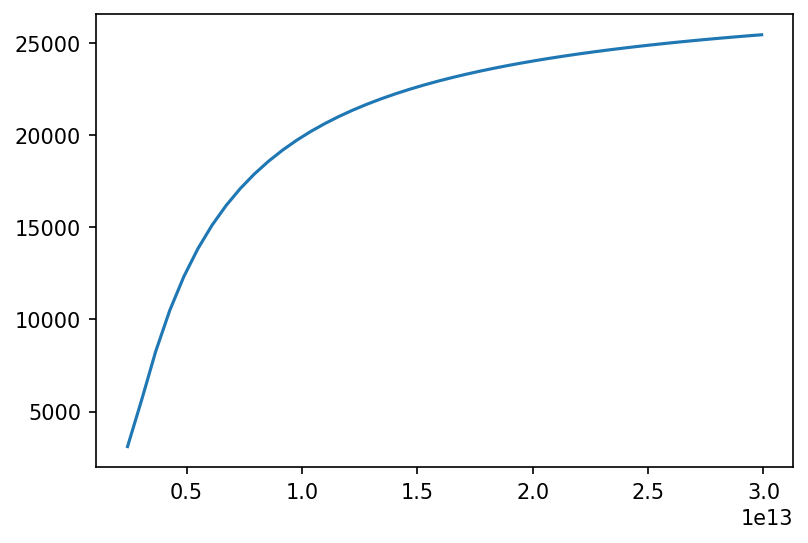

In [33]:
def beta_velocity(r):
    v_0    = 3.00e+3   # m/s
    v_exp  = 2.84e+4   # m/s
    r_dust = 2.38e12   # m
    beta   = 1.5       #
    return v_0 + (v_exp - v_0) * (1.0 - r_dust/r)**beta

rs = np.linspace(0, (200*units.au).si.value)

plt.figure(dpi=150)
plt.plot(rs, beta_velocity(rs))

In [ ]:
# Fixed parameters
v_trb = 1.50e+2
v_max = 2.84e+4
v_los = obj.radial_velocity.si.value

In [21]:
model = TensorModel(
    sizes = (s_x, s_y, s_z),
    shape = (obs.shape[0], obs.shape[1], 128),
)

r_x, r_y, r_z = model.get_radial_direction(origin='centre')
p_x, p_y, p_z = model.get_coords          (origin='centre')
r             = model.get_radius          (origin='centre')
inverse_r     = r.min() / r

# Define and initialize the model parameters
# model['log_M'           ] = np.log(constants.M_sun.si.value)
model['log_CO'          ] = np.log(1.0e+11 * inverse_r**2)
model['log_temperature' ] = np.log(2.0e+3  * inverse_r)
model['velocity_x/v_max'] = r_x * beta_velocity(r) / v_max
model['velocity_y/v_max'] = r_y * beta_velocity(r) / v_max
model['velocity_z/v_max'] = r_z * beta_velocity(r) / v_max
# model['log_v_los'       ] = np.log(v_los.si.value)

model.free_all()
# model.fix('log_temperature')
model.fix(['velocity_x/v_max'])
model.fix(['velocity_y/v_max'])
model.fix(['velocity_z/v_max'])
# model.fix('log_v_turbulence')
# model.fix('log_v_los')

model.info()

Variable key:              Free/Fixed:   Field:    Min:           Mean:          Max:
  log_CO                     Free          True     +1.457e+01     +1.581e+01     +2.533e+01
  log_temperature            Free          True     +2.221e+00     +2.843e+00     +7.601e+00
  velocity_x/v_max           Fixed         True     -1.000e+00     -1.160e-17     +1.000e+00
  velocity_y/v_max           Fixed         True     -1.000e+00     -1.133e-18     +1.000e+00
  velocity_z/v_max           Fixed         True     -1.000e+00     +1.813e-19     +1.000e+00
sizes: (54603456820797.37, 54603456820797.37, 54603456820797.37)
shape: (35, 35, 128)


In [22]:
# M = torch.exp(model['log_M'])

# hydrodynamics = Hydrodynamics(
#     gamma  = 1.2,
#     mu     = 2.381 * constants.u.si.value,
#     f_x    = -constants.G.si.value * M * r_x / r**2,
#     f_y    = -constants.G.si.value * M * r_y / r**2,
#     f_z    = -constants.G.si.value * M * r_z / r**2,
#     Lambda = 0.0
# )

spherical_loss = SphericalLoss(
    model  =  model,
    origin = 'centre'
)

# loss = Loss(['rep', 'reg', 'sym'] + list(hydrodynamics.loss_keys.values()))
# loss = Loss(['rep', 'reg', 'sym'])
loss = Loss(['rep', 'reg', 'ext'])
# loss = Loss(['rep'])

In [23]:
def forward(model, freqs):
    """
    Forward model: image the given TensorModel along the last axis, 
    at the given frequencies, assuming local thermodynamical equilibrium (LTE).
    """
    img = line.LTE_image_along_last_axis(
        density      = torch.exp(model['log_CO']),
        temperature  = torch.exp(model['log_temperature']),
        v_turbulence = v_trb,
        velocity_los = v_los + v_max * model['velocity_z/v_max'],
        frequencies  = freqs,
        dx           = model.dx(model.dim()-1)
    )

    # Avoid negative values (should probably avoid these earlier...)
    img = torch.abs(img)

    # Convert to Jy/pixel
    img *= model.dx(0) * model.dx(1) / obj.distance.si.value**2 / 1.0e-26
    
    # Convolve with beam (i.e. convert to Jy/beam)
    img = beam.torch_apply(img)

    return img

In [24]:
img = forward (model, freqs)

def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), obs[i,j,:].data)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), img[i,j,:].data, marker='x')
    plt.axvline(line.freq_to_velo(line.frequency * units.Hz) - v_los, c='k')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function __main__.plot(i, j)>

In [234]:
def fit(loss, model, data, N_epochs=10, lr=1.0e-1):

    optimizer = Adam(model.free_parameters(), lr=lr)

    for _ in tqdm(range(N_epochs)):
        
        # Run forward model
        img = forward(model, freqs)
 
        # Reproduction loss between model image and observations
        loss['rep'] = torch.nn.functional.mse_loss(img, obs)

        # Regularisation loss
        loss['reg'] = model.apply_to_fields(diff_loss)
        
        loss['ext'] = torch.mean(torch.exp(model['log_CO'])) + torch.mean(torch.exp(model['log_temperature']))

        # Spherical symmetry loss
        # loss['sym'] = model.apply_to_fields(
            # func    = spherical_loss.eval,
            # exclude = ['velocity_x/v_max', 'velocity_y/v_max', 'velocity_z/v_max'],
            # include = [model['velocity_x/v_max']**2 + model['velocity_y/v_max']**2 + model['velocity_z/v_max']**2]
        # )

        # loss = hydrodynamics.add_steady_state_loss(
        #     model   = model,
        #     loss    = loss,
        #     log_rho = model['log_CO'],
        #     log_tmo = model['log_temperature'],
        #     v_x     = v_max * model['velocity_x/v_max'],
        #     v_y     = v_max * model['velocity_y/v_max'],
        #     v_z     = v_max * model['velocity_z/v_max'],
        # )
        
        # Set gradients to zero
        optimizer.zero_grad()
        # Backpropagate gradients
        loss.tot().backward()
        # Update parameters
        optimizer.step()

100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


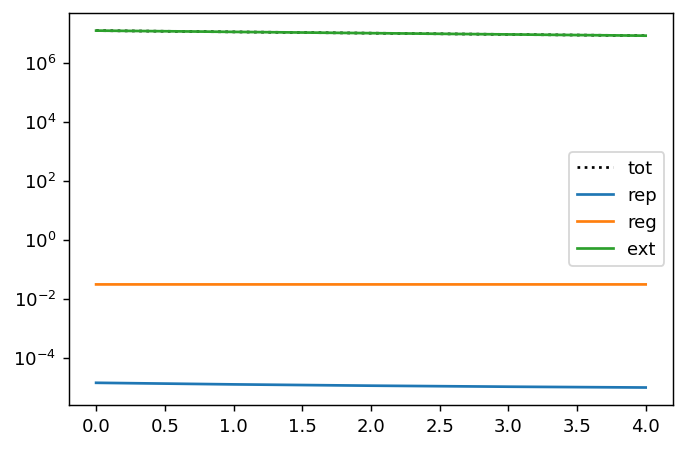

In [235]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [236]:
loss.renormalise_all()
loss.reset()

100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


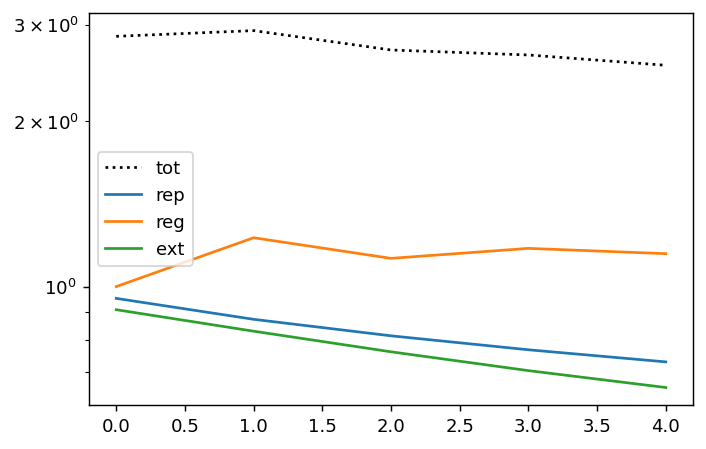

In [237]:
fit(loss, model, obs, N_epochs=5, lr=1.0e-1)
loss.plot()

In [238]:
loss.weight['rep'] *= 1.0e+2
loss.weight['reg'] *= 1.0e-0
loss.weight['ext'] *= 1.0e-0

In [247]:
img = forward (model, freqs)

In [248]:
def plot(i,j):
    plt.figure(dpi=150)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), obs[i,j,:].data)
    plt.plot   (line.freq_to_velo(freqs          * units.Hz), img[i,j,:].data, marker='x')
    plt.axvline(line.freq_to_velo(line.frequency * units.Hz) - v_los, c='k')
interact(plot, i=(0, img.shape[0]-1), j=(0, img.shape[1]-1) )

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function __main__.plot(i, j)>

In [249]:
def plot(f):
    fig, axs = plt.subplots(1, 2, dpi=150)
    axs[0].set_title('Observation')
    axs[1].set_title('Model')
    axs[0].imshow(obs[:,:,f].data, vmin=obs.data.min(), vmax=obs.data.max())
    axs[1].imshow(img[:,:,f].data, vmin=img.data.min(), vmax=img.data.max())
interact(plot, f=(0, img.shape[2]-1))

interactive(children=(IntSlider(value=12, description='f', max=24), Output()), _dom_classes=('widget-interact'…

<function __main__.plot(f)>

In [250]:
plot_cube_2D(model['log_CO'])

interactive(children=(IntSlider(value=63, description='z', max=127), Output()), _dom_classes=('widget-interact…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [243]:
plot_cube_2D(model['log_temperature'])

interactive(children=(IntSlider(value=63, description='z', max=127), Output()), _dom_classes=('widget-interact…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [244]:
plot_cube_2D(model['velocity_z/v_max'])

interactive(children=(IntSlider(value=63, description='z', max=127), Output()), _dom_classes=('widget-interact…

<function p3droslo.plot.plot_cube_2D.<locals>.plot(z)>

In [245]:
plot_spectrum(model['log_CO'])

interactive(children=(IntSlider(value=17, description='i', max=34), IntSlider(value=17, description='j', max=3…

<function p3droslo.plot.plot_spectrum.<locals>.plot(i, j)>

100%|██████████| 300/300 [03:17<00:00,  1.52it/s]


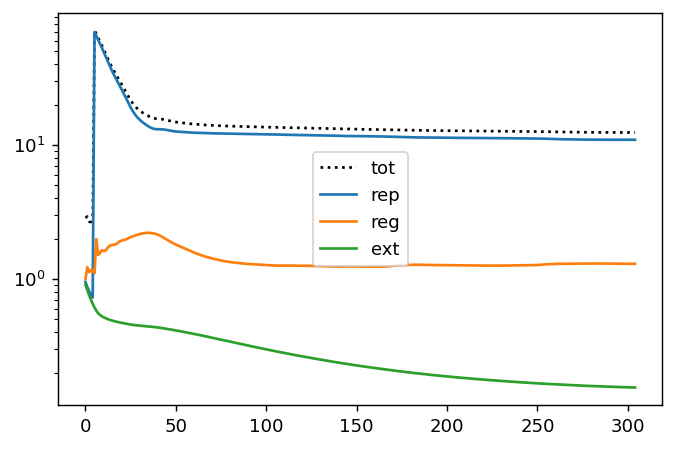

In [246]:
fit(loss, model, obs, N_epochs=300, lr=1.0e-1)
loss.plot()

In [251]:
fit(loss, model, obs, N_epochs=500, lr=1.0e-0)
loss.plot()

  6%|▌         | 29/500 [00:18<05:04,  1.55it/s]

In [ ]:
model.save('IK_Tau.h5')

100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


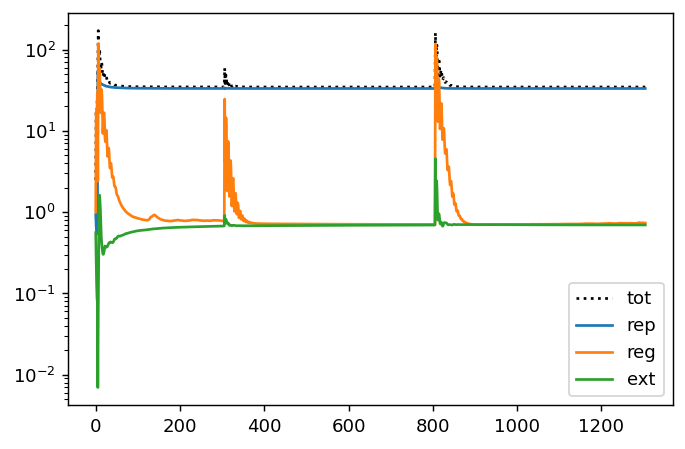

In [139]:
fit(loss, model, obs, N_epochs=500, lr=3.0)
loss.plot()